In [1]:
import os, math, numpy as np, pandas as pd
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader, NeighborLoader
from torch_geometric.nn import MessagePassing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix
import networkx as nx

In [2]:
data = pd.read_parquet("custom_features_dataset.parquet")

EDGE_COLS = [
    'Bwd Packet Length Min', 'Protocol_6', 'Bwd Packets/s', 'FWD Init Win Bytes',
    'Packet Length Std', 'FIN Flag Count', 'SrcPortRange_registered',
    'Packet Length Min', 'Fwd Seg Size Min', 'DstPortRange_well_known',
    'Bwd IAT Total', 'SYN Flag Count', 'Bwd Packet Length Std'
]
ID_COLS = ['Src IP','Dst IP','Timestamp']
LABEL_COL = 'target' 

In [3]:
# def time_posenc(t, periods=(60, 300, 3600)):
#     # t: numpy array of epoch seconds
#     feats = []
#     for P in periods:
#         w = 2*math.pi/P
#         feats.append(np.sin(w*t))
#         feats.append(np.cos(w*t))
#     return np.stack(feats, axis=1)  # [N, 2*len(periods)]

def bin_time(df, bin_seconds=300):
    # Expect df['Timestamp'] as datetime or string; convert to seconds
    ts = pd.to_datetime(df['Timestamp'], errors='coerce', utc=True).astype('int64') // 10**9
    df = df.copy()
    df['_epoch'] = ts
    df['_bin'] = (ts // bin_seconds).astype(int)
    return df

In [4]:
def compute_node_centralities(df: pd.DataFrame,
                              ip2idx: dict,
                              src_col: str = "Src IP",
                              dst_col: str = "Dst IP",
                              approx_betweenness: bool = True,
                              k_bt: int = 2000,
                              pagerank_tol: float = 1e-6,
                              max_ktruss: int = 6) -> np.ndarray:
    """
    Returns C: [N_nodes, 5] -> [degree, betweenness, closeness, pagerank, ktruss_level], z-scored per column.
    """
    # Build directed simple graph (unique edges)
    H = nx.DiGraph()
    edges = list(zip(df[src_col].astype(str), df[dst_col].astype(str)))
    H.add_edges_from(edges)

    # Degree (total degree in directed graph)
    deg = dict(H.degree())

    # Betweenness (approximate for speed)
    if approx_betweenness:
        num_k = min(k_bt, max(10, H.number_of_nodes()))
        btw = nx.betweenness_centrality(H, k=num_k, seed=42, normalized=True)
    else:
        btw = nx.betweenness_centrality(H, normalized=True)

    # Closeness
    clo = nx.closeness_centrality(H)

    # PageRank
    pr = nx.pagerank(H, max_iter=200, tol=pagerank_tol)

    # k-truss level (works on undirected simple graph)
    Hu = nx.Graph()
    Hu.add_edges_from(H.to_undirected().edges())
    ktruss_level = {n: 0 for n in Hu.nodes()}
    for k in range(3, max_ktruss + 1):
        try:
            Tk = nx.k_truss(Hu, k)
        except nx.NetworkXError:
            break
        for n in Tk.nodes():
            ktruss_level[n] = max(ktruss_level.get(n, 0), k)

    # Pack per ip2idx order
    N = len(ip2idx)
    C = np.zeros((N, 5), dtype=float)
    for ip, idx in ip2idx.items():
        C[idx, 0] = float(deg.get(ip, 0.0))
        C[idx, 1] = float(btw.get(ip, 0.0))
        C[idx, 2] = float(clo.get(ip, 0.0))
        C[idx, 3] = float(pr.get(ip, 0.0))
        C[idx, 4] = float(ktruss_level.get(ip, 0.0))

    # z-score per column
    mu = C.mean(axis=0, keepdims=True)
    sd = C.std(axis=0, keepdims=True) + 1e-8
    C = (C - mu) / sd
    return C  # [N, 5]

In [13]:
def build_snapshots(df, scaler_edge=None, fit_scaler=False, bin_seconds=300, device='cpu', include_per_bin_feats=True):
    """
    Returns:
      snapshots: list[Data] in time order
      ip2idx: dict mapping IP -> node index (per full dataset, stable across train/test)
      scaler_edge: fitted StandardScaler for edge features
      edge_cols_kept: list of columns used (existing + non-NA + time enc + centralities names)
    """
    # Keep only available columns
    edge_cols = [c for c in EDGE_COLS if c in df.columns]
    cols_needed = ID_COLS + edge_cols + [LABEL_COL]
    cols_needed = [c for c in cols_needed if c in df.columns]
    df = df[cols_needed].dropna(subset=['Src IP','Dst IP'])
    df = bin_time(df, bin_seconds=bin_seconds)

    edge_cols = [c for c in EDGE_COLS if c in df.columns]
    for c in edge_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df[edge_cols] = df[edge_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)

    # Edge feature scaler
    if scaler_edge is None:
        scaler_edge = StandardScaler()
        fit_scaler = True
    if fit_scaler and len(edge_cols) > 0:
        scaler_edge.fit(df[edge_cols].astype(float).values)

    # Stable node indexing across all snapshots
    ips = pd.Index(pd.unique(pd.concat([df['Src IP'], df['Dst IP']]).astype(str)))
    ip2idx = {ip:i for i,ip in enumerate(ips)}
    n_nodes = len(ip2idx)

    # --- NEW: centralities over the full graph ---
    C = compute_node_centralities(df, ip2idx, src_col='Src IP', dst_col='Dst IP')  # [N, 5]

    snapshots = []
    prev_activity = defaultdict(int)  # lag-1 activity per node

    # iterate bins
    for b, g in df.sort_values('_bin').groupby('_bin'):
        # Map nodes
        src = g['Src IP'].map(ip2idx).astype(int).values
        dst = g['Dst IP'].map(ip2idx).astype(int).values
        edge_index = torch.tensor(np.vstack([src, dst]), dtype=torch.long)

        # Edge attributes = scaled flow features + time encoding
        if len(edge_cols) > 0:
            eX = scaler_edge.transform(g[edge_cols].astype(float).values)
        else:
            eX = np.empty((len(g), 0), dtype=float)
        # tfe = time_posenc(g['_epoch'].values)  # [E, 2*len(periods)]
        # edge_attr_np = np.hstack([eX, tfe])
        edge_attr_np = np.hstack([eX])
        edge_attr = torch.tensor(edge_attr_np, dtype=torch.float)
        edge_attr = torch.nan_to_num(edge_attr, nan=0.0, posinf=1e6, neginf=-1e6)

        # Labels (edge-level)
        y = torch.tensor(g[LABEL_COL].astype(int).values, dtype=torch.long)

        # Node features:
        #   (paper) centralities C; (yours) optional per-bin degrees + prev_activity
        if include_per_bin_feats:
            out_deg = np.bincount(src, minlength=n_nodes)
            in_deg  = np.bincount(dst, minlength=n_nodes)
            deg     = (out_deg + in_deg).reshape(-1,1)
            node_feat = np.hstack([
                in_deg.reshape(-1,1),
                out_deg.reshape(-1,1),
                deg,
                np.array([prev_activity[i] for i in range(n_nodes)]).reshape(-1,1)
            ])
            node_feat = np.log1p(node_feat)
            x_np = np.hstack([node_feat, C])  # [N, 4 + 5]
        else:
            x_np = C  # strict paper-style init

        x = torch.tensor(x_np, dtype=torch.float)
        x = torch.nan_to_num(x, nan=0.0, posinf=1e6, neginf=-1e6)

        data = Data(
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=y
        )
        data._bin = int(b)
        snapshots.append(data)

        # Update prev_activity for next bin (count edges touched by node this bin)
        touched = np.bincount(np.concatenate([src, dst]), minlength=n_nodes)
        for i, c in enumerate(touched):
            prev_activity[i] = int(c)

    # Column names returned (only for info)
    # time_cols = [f'time_{i}' for i in range(tfe.shape[1])]
    # cent_cols = ['cent_degree','cent_betweenness','cent_closeness','cent_pagerank','cent_ktruss']
    # edge_cols_used = edge_cols + time_cols + cent_cols

    # time_cols = [f'time_{i}' for i in range(tfe.shape[1])]
    cent_cols = ['cent_degree','cent_betweenness','cent_closeness','cent_pagerank','cent_ktruss']
    edge_cols_used = edge_cols + cent_cols
    return snapshots, ip2idx, scaler_edge, edge_cols_used

In [14]:
class EdgeGraphSAGEConv(MessagePassing):
    """
    Edge-aware GraphSAGE (E-GraphSAGE-like):
      m_ij = gate([x_i, x_j, e_ij]) * φ( Wj x_j + Wi x_i + We e_ij )
      h_i' = Norm( mean_j m_ij + Wself x_i )     (residual)
    """
    def __init__(self, in_channels: int, edge_in: int, out_channels: int, aggr: str = "mean", dropout: float = 0.0):
        super().__init__(aggr=aggr, node_dim=0)
        self.lin_src  = nn.Linear(in_channels, out_channels, bias=False)
        self.lin_dst  = nn.Linear(in_channels, out_channels, bias=False)
        self.lin_edge = nn.Linear(edge_in,    out_channels, bias=False)
        self.lin_self = nn.Linear(in_channels, out_channels, bias=True)

        # Small gate that decides how much of each message passes through
        self.gate = nn.Sequential(
            nn.Linear(in_channels + in_channels + edge_in, out_channels // 2),
            nn.ReLU(),
            nn.Linear(out_channels // 2, 1)
        )

        self.norm = nn.LayerNorm(out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)  # -> [N, Fout]
        out = out + self.lin_self(x)  # residual
        out = self.norm(out)
        return out

    def message(self, x_i: torch.Tensor, x_j: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        msg_raw = self.lin_src(x_j) + self.lin_dst(x_i) + self.lin_edge(edge_attr)
        g = torch.sigmoid(self.gate(torch.cat([x_i, x_j, edge_attr], dim=-1)))
        msg = F.relu(msg_raw) * g
        return self.dropout(msg)

    def update(self, aggr_out: torch.Tensor) -> torch.Tensor:
        return aggr_out

In [15]:
class GraphTimeEdgeClassifier(nn.Module):
    """
    E-GraphSAGE-style backbone that uses edge attributes inside message passing
    AND in the final edge-level head.
    """
    def __init__(self, in_node: int, in_edge: int, hidden: int = 64, num_layers: int = 2, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        layers = []
        dims = [in_node] + [hidden] * num_layers
        for i in range(num_layers):
            layers.append(EdgeGraphSAGEConv(dims[i], in_edge, dims[i+1], aggr="mean", dropout=dropout))
        self.convs = nn.ModuleList(layers)

        # Edge MLP head: combine node embeddings and edge features
        edge_head_in = (2 * hidden) + in_edge + hidden + hidden  # [h_s, h_d, e, |h_s-h_d|, h_s*h_d]
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_head_in, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 2)
        )

    def forward(self, data: Data) -> torch.Tensor:
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        for conv in self.convs:
            x = conv(x, edge_index, edge_attr)
            x = F.relu(x)
            x = self.dropout(x)

        src, dst = edge_index
        h_s, h_d = x[src], x[dst]
        h_abs = torch.abs(h_s - h_d)
        h_mul = h_s * h_d
        z = torch.cat([h_s, h_d, edge_attr, h_abs, h_mul], dim=-1)

        logits = self.edge_mlp(z)
        return logits

In [16]:
def run_epoch_fullgraph(model, snapshots, optimizer=None, device='cpu'):
    is_train = optimizer is not None
    total_loss, total_correct, total_edges = 0.0, 0, 0
    ce = nn.CrossEntropyLoss()
    all_preds, all_trues = [], []

    for data in snapshots:
        data = data.to(device)
        logits = model(data)
        if is_train:
            loss = ce(logits, data.y)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
            total_loss += float(loss.item()) * data.y.numel()
        with torch.no_grad():
            pred = logits.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_trues.append(data.y.cpu().numpy())
            total_correct += int((pred == data.y).sum())
            total_edges += int(data.y.numel())

    # Metrics
    if all_trues:
        y_true = np.concatenate(all_trues)
        y_pred = np.concatenate(all_preds)
        weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        # FPR: FP / N_negatives
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0,0,0,0)
        fpr = fp / max(1, (fp + tn))
    else:
        weighted_f1, fpr = float('nan'), float('nan')

    avg_loss = (total_loss / max(1, total_edges)) if is_train else None
    acc = total_correct / max(1, total_edges)
    return avg_loss, acc, weighted_f1, fpr

In [17]:
def run_epoch_neighbor(model, snapshot: Data, optimizer=None, device='cpu',
                       num_neighbors=[25,10], batch_size=4096, shuffle=True):
    is_train = optimizer is not None
    ce = nn.CrossEntropyLoss()
    total_loss, total_correct, total_edges = 0.0, 0, 0
    all_preds, all_trues = [], []

    model.train() if is_train else model.eval()

    loader = NeighborLoader(snapshot, num_neighbors=num_neighbors, batch_size=batch_size, shuffle=shuffle)
    for batch in loader:
        batch = batch.to(device)
        logits = model(batch)

        if is_train:
            loss = ce(logits, batch.y)
            if not torch.isfinite(loss):
                # skip this minibatch if something went bad
                continue
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
            total_loss += float(loss.item()) * batch.y.numel()

        with torch.no_grad():
            pred = logits.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_trues.append(batch.y.cpu().numpy())
            total_correct += int((pred == batch.y).sum())
            total_edges += int(batch.y.numel())

    # Metrics
    if all_trues:
        y_true = np.concatenate(all_trues)
        y_pred = np.concatenate(all_preds)
        weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0,0,0,0)
        fpr = fp / max(1, (fp + tn))
    else:
        weighted_f1, fpr = float('nan'), float('nan')

    avg_loss = (total_loss / max(1, total_edges)) if is_train else None
    acc = total_correct / max(1, total_edges)
    return avg_loss, acc, weighted_f1, fpr

In [23]:
split_ratio = 0.8
train_df = data[:int(len(data)*split_ratio)]
test_df = data[int(len(data)*split_ratio):]

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [25]:
# Build train snapshots (fit scaler)
train_snaps, train_ip2idx, scaler_edge, edge_cols_used = build_snapshots(
    train_df, scaler_edge=None, fit_scaler=True, bin_seconds=300, device=device, include_per_bin_feats=False
)

# Build test snapshots (reuse scaler; separate ip2idx for strict inductive)
test_snaps, test_ip2idx, _, _ = build_snapshots(
    test_df, scaler_edge=scaler_edge, fit_scaler=False, bin_seconds=300, device=device, include_per_bin_feats=False
)

In [26]:
in_node = train_snaps[0].x.size(1)         # now includes centralities (+ optional per-bin feats)
in_edge = train_snaps[0].edge_attr.size(1) # edge features + time enc
model = GraphTimeEdgeClassifier(in_node=in_node, in_edge=in_edge,
                                hidden=32, num_layers=2, dropout=0.2).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [ ]:
EPOCHS = 10

for epoch in range(1, EPOCHS+1):
    tr_losses, tr_accs, tr_f1s, tr_fprs = [], [], [], []
    for snap in train_snaps:
        tr_loss, tr_acc, tr_f1, tr_fpr = run_epoch_neighbor(model, snap, optimizer=opt, device=device,
                                                            num_neighbors=[25,10], batch_size=4096, shuffle=True)
        tr_losses.append(tr_loss if tr_loss is not None else 0.0)
        tr_accs.append(tr_acc); tr_f1s.append(tr_f1); tr_fprs.append(tr_fpr)
    # Eval on test with neighbor sampling (no optimizer)
    te_accs, te_f1s, te_fprs = [], [], []
    for snap in test_snaps:
        _, te_acc, te_f1, te_fpr = run_epoch_neighbor(model, snap, optimizer=None, device=device,
                                                        num_neighbors=[25,10], batch_size=4096, shuffle=False)
        te_accs.append(te_acc); te_f1s.append(te_f1); te_fprs.append(te_fpr)

    print(f"Epoch {epoch:02d} | "
            f"train loss {np.mean(tr_losses):.4f} | train acc {np.mean(tr_accs):.4f} | "
            f"train F1 {np.mean(tr_f1s):.4f} | train FPR {np.mean(tr_fprs):.4f} | "
            f"test acc {np.mean(te_accs):.4f} | test F1 {np.mean(te_f1s):.4f} | test FPR {np.mean(te_fprs):.4f}")


Epoch 01 | train loss 0.0005 | train acc 0.9999 | train F1 0.9999 | train FPR 0.0001 | test acc 0.9999 | test F1 0.9999 | test FPR 0.0000
Epoch 02 | train loss 0.0001 | train acc 1.0000 | train F1 1.0000 | train FPR 0.0000 | test acc 0.9999 | test F1 0.9999 | test FPR 0.0000
Epoch 03 | train loss 0.0001 | train acc 1.0000 | train F1 1.0000 | train FPR 0.0000 | test acc 0.9999 | test F1 0.9999 | test FPR 0.0000
Epoch 04 | train loss 0.0000 | train acc 1.0000 | train F1 1.0000 | train FPR 0.0000 | test acc 0.9999 | test F1 0.9999 | test FPR 0.0000
Epoch 05 | train loss 0.0000 | train acc 1.0000 | train F1 1.0000 | train FPR 0.0000 | test acc 1.0000 | test F1 1.0000 | test FPR 0.0000
Epoch 06 | train loss 0.0000 | train acc 1.0000 | train F1 1.0000 | train FPR 0.0000 | test acc 1.0000 | test F1 1.0000 | test FPR 0.0000
Epoch 07 | train loss 0.0001 | train acc 1.0000 | train F1 1.0000 | train FPR 0.0000 | test acc 0.9999 | test F1 0.9999 | test FPR 0.0000
Epoch 08 | train loss 0.0000 | tra

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_with_confusion(model, snapshots, device='cpu'):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for data in snapshots:
            data = data.to(device)
            logits = model(data)
            preds = logits.argmax(dim=1).cpu().numpy()
            labels = data.y.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    print("📊 Classification Report:")
    print(report)

    return cm, report

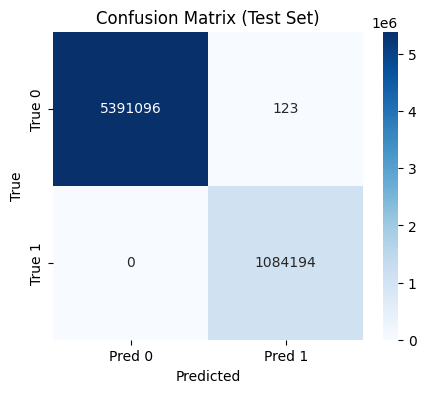

📊 Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   5391219
           1     0.9999    1.0000    0.9999   1084194

    accuracy                         1.0000   6475413
   macro avg     0.9999    1.0000    1.0000   6475413
weighted avg     1.0000    1.0000    1.0000   6475413



: 

In [ ]:
cm, report = evaluate_with_confusion(model, test_snaps, device=device)